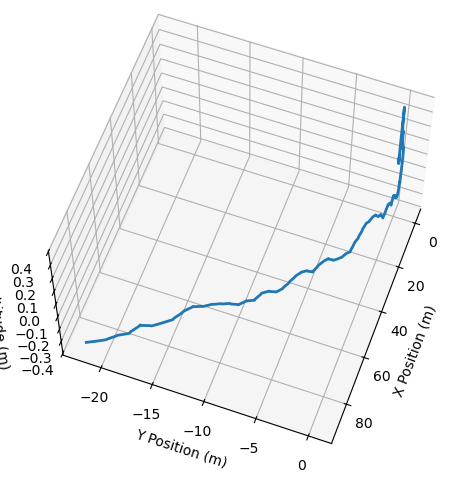

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from filterpy.kalman import ExtendedKalmanFilter

# --- UTILITY FUNCTIONS ---
def quaternion_conjugate(q):
    return np.array([q[0], -q[1], -q[2], -q[3]])

def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

def quaternion_rotate(q, v):
    """Rotate a 3-vector v by quaternion q (w,x,y,z)."""
    qv = np.concatenate([[0.0], v])
    return quaternion_multiply(
        quaternion_multiply(q, qv),
        quaternion_conjugate(q)
    )[1:]

def normalize_quat(q):
    return q / np.linalg.norm(q)

def quat_from_gyro(q, omega, dt):
    dq = np.concatenate([[0.0], omega]) * dt / 2.0
    q_dot = quaternion_multiply(q, dq)
    return normalize_quat(q + q_dot)

def pressure_to_altitude(p, p0):
    """Barometric formula: return altitude above reference p0."""
    return 44330.0 * (1.0 - (p / p0)**(1/5.255))

# measurement prediction functions
def hx_accel(x):
    q = x[:4]
    g = np.array([0.0, 0.0, 9.81])
    return quaternion_rotate(q, g)

def hx_mag(x):
    q = x[:4]
    global m_ref
    return quaternion_rotate(q, m_ref)

def h_all(x):
    return np.hstack([hx_accel(x), hx_mag(x)])

# numeric Jacobian
def numeric_jacobian(func, x, *args):
    eps = 1e-6
    f0 = func(x, *args)
    m = len(f0)
    n = len(x)
    J = np.zeros((m, n))
    for j in range(n):
        xp = x.copy()
        xp[j] += eps
        fp = func(xp, *args)
        J[:, j] = (fp - f0) / eps
    return J

# 1) Load & preprocess
csv_path   = '/Users/benjaminli/Downloads/S_82924/PANORAMIC_RIGHT_all_sensors.csv'
start_time = '2024-05-17 14:05:49'
end_time   = '2024-05-17 14:05:56'

df = pd.read_csv(csv_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)
df = df.interpolate(method='linear', limit_direction='both')
df = df.dropna(subset=['GYRO_x','GYRO_y','GYRO_z',
                       'HE_ACC_x','HE_ACC_y','HE_ACC_z',
                       'MAGNETIC_FIELD_x','MAGNETIC_FIELD_y','MAGNETIC_FIELD_z',
                       'PRESSURE']).reset_index(drop=True)
mask = ((df['timestamp']>=pd.to_datetime(start_time)) &
        (df['timestamp']<=pd.to_datetime(end_time)))
df = df.loc[mask].reset_index(drop=True)
N = len(df)
if N < 2:
    raise ValueError("Not enough data in the time window.")

# 2) EKF setup
ekf = ExtendedKalmanFilter(dim_x=7, dim_z=6)
def initialize_ekf(ekf):
    ekf.x = np.zeros(7)
    ekf.x[:4] = [1, 0, 0, 0]
    ekf.P = np.eye(7) * 1e-3
    ekf.Q = np.zeros((7,7)); ekf.Q[4:,4:] = np.eye(3) * 1e-5
    R = np.eye(6)
    R[:3,:3] *= 0.1 # accelerometer
    R[3:,3:] *= 0.1 # magnetometer
    ekf.R = R
initialize_ekf(ekf)

# compute inertial mag reference
d0 = df.loc[0]
mag0 = np.array([d0.MAGNETIC_FIELD_x, d0.MAGNETIC_FIELD_y, d0.MAGNETIC_FIELD_z])
mag0_n = mag0 / np.linalg.norm(mag0)
m_ref = quaternion_multiply(quaternion_conjugate(ekf.x[:4]),
           np.concatenate([[0], mag0_n]))
m_ref = quaternion_multiply(m_ref, ekf.x[:4])[1:]

# 3) Prepare storage & HPF
q = ekf.x[:4].copy()
acc_lin = np.zeros((N,3)); acc_hp = np.zeros((N,3))
vel = np.zeros((N,3)); pos = np.zeros((N,3)); alt = np.zeros(N)
p0 = d0.PRESSURE
prev_t = df.loc[0,'timestamp']
prev_a_lin = np.zeros(3)
# seed HPF with zero
acc_hp[0] = 0; vel[0] = 0; pos[0] = 0; alt[0] = pressure_to_altitude(d0.PRESSURE, p0)

# HPF constant
tau = 1.0 / (2.0 * np.pi * 0.05)

# 4) Main loop
def fx(x, dt, u):
    return np.concatenate([quat_from_gyro(x[:4], u, dt), x[4:]])

def F_jacobian(x, dt, u):
    return numeric_jacobian(lambda xx: fx(xx, dt, u), x)

def H_jacobian(x):
    return numeric_jacobian(h_all, x)

# choose your LPF cutoff
fc_lp  = 1.0  
tau_lp = 1.0 / (2.0 * np.pi * fc_lp)

# before loop:
acc_lpf_state = np.zeros(3)

for i in range(1, N):
    row = df.loc[i]
    t1 = row.timestamp
    dt = (t1 - prev_t).total_seconds()
    prev_t = t1
    if dt <= 0 or dt > 0.05:
        continue

    gyro = np.array([row.GYRO_x, row.GYRO_y, row.GYRO_z]) * np.pi/180
    accel = np.array([row.HE_ACC_x, row.HE_ACC_y, row.HE_ACC_z])
    mag = np.array([row.MAGNETIC_FIELD_x, row.MAGNETIC_FIELD_y, row.MAGNETIC_FIELD_z])
    mag_n = mag / np.linalg.norm(mag)

    # Predict step
    # Set EKF motion model and Jacobian
    ekf.fx = lambda x: np.concatenate([quat_from_gyro(x[:4], gyro, dt), x[4:]])
    ekf.F  = numeric_jacobian(ekf.fx, ekf.x)

    ekf.predict()

    # Update step
    z = np.hstack([accel, mag_n])
    ekf.hx = h_all
    ekf.H  = lambda x: numeric_jacobian(h_all, x)
    ekf.update(z, HJacobian=ekf.H, Hx=ekf.hx)

    # extract quaternion
    q = normalize_quat(ekf.x[:4])

    # gravity compensation
    g_s = quaternion_rotate(q, np.array([0, 0, 9.81]))
    a_lin = accel - g_s
    acc_lin[i] = a_lin

    # high-pass filter
    alpha     = tau / (tau + dt)
    acc_hp[i] = alpha * (acc_hp[i-1] + a_lin - prev_a_lin)
    prev_a_lin = a_lin

    alpha_lp = dt / (dt + tau_lp)
    acc_lpf_state = alpha_lp * acc_hp[i] + (1.0 - alpha_lp) * acc_lpf_state
    acc_hp[i]     = acc_lpf_state

    # # uniformly scale down the estimate
    # scale_acc = 1.0 / 10.0   # shrink accel amplitudes to 20%
    # acc_hp[i] *= scale_acc


    # Integrate
    if i > 1:
        vel[i] = vel[i-1] + 0.5 * (acc_hp[i] + acc_hp[i-1]) * dt
        pos[i] = pos[i-1] + 0.5 * (vel[i] + vel[i-1]) * dt

    alt[i] = pressure_to_altitude(row.PRESSURE, p0)

# 5) Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos[:,0], pos[:,1], alt, lw=2)

# Set viewing angles
ax.view_init(elev=60, azim=20)  # Elevation (up/down), Azimuth (around)

ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Altitude (m)')
plt.tight_layout()
plt.show()





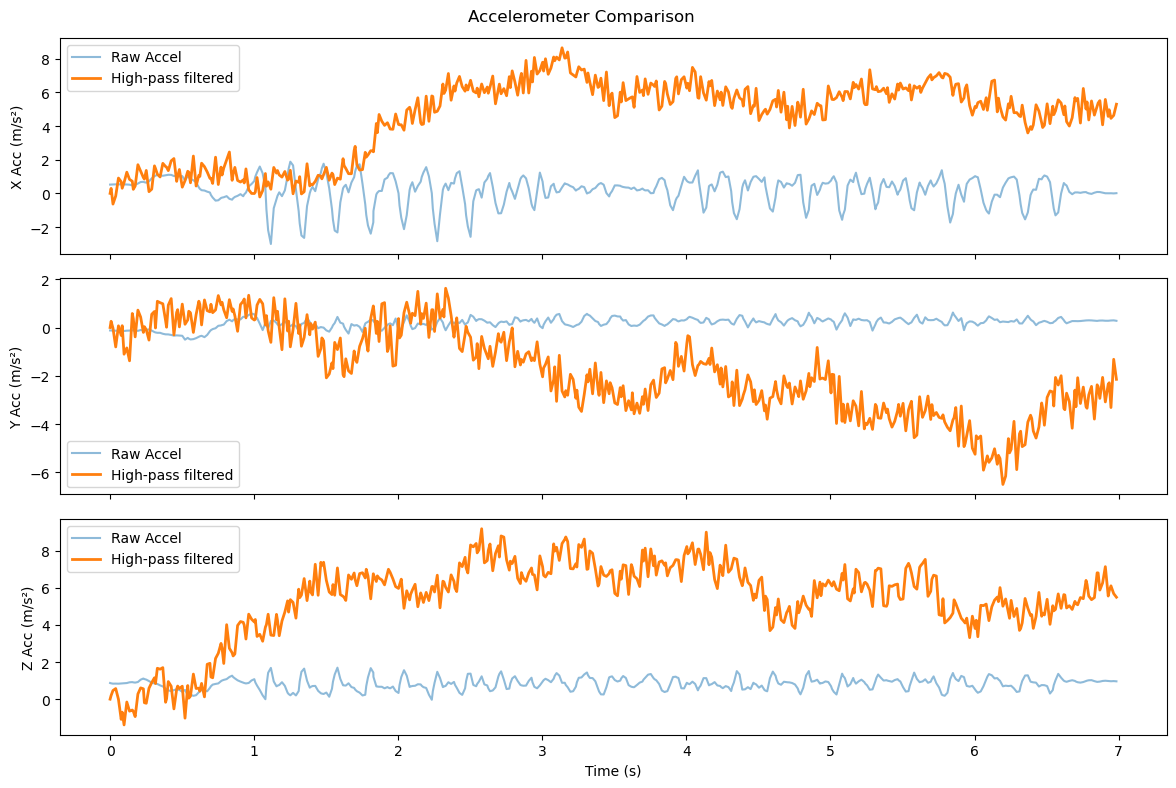

In [35]:
# Extract accel vectors
accel_all = df[['HE_ACC_x','HE_ACC_y','HE_ACC_z']].values

# Plot comparison of raw vs. gravity-compensated vs. HPF
t = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds()

fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
labels = ['X', 'Y', 'Z']
for i in range(3):
    axs[i].plot(t, accel_all[:,i], label='Raw Accel', alpha=0.5)
    axs[i].plot(t, acc_hp[:,i], label='High-pass filtered', lw=2)
    axs[i].set_ylabel(f'{labels[i]} Acc (m/s²)')
    axs[i].legend()
axs[-1].set_xlabel('Time (s)')
plt.suptitle('Accelerometer Comparison')
plt.tight_layout()
plt.show()
